<a href="https://colab.research.google.com/github/yugeenzsm/AI-ML-/blob/main/Workshop9_AIML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence to Sequence Model.
___
In this Notebook we will try to build and understand a Seq to Seq Model for Machine Translations.

# Download the dataset:

The following script will download the dataset and stores the file in designated folder.

Please change the folder path as per your file structure.


In [2]:
import os
root_path = "/content/drive/MyDrive/csv"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import os

# Path to the original data file
data_path = "/content/drive/MyDrive/csv/npi.txt"

# Read the .txt file into a DataFrame
lines = pd.read_table(data_path, names=['source', 'target', 'comments'])

# Drop the 'comments' column if it exists
if 'comments' in lines.columns:
    lines = lines.drop(columns=['comments'])

# Path to save the cleaned CSV file
csv_path = os.path.join("/content/drive/MyDrive/csv", "raw_data.csv")

# Save as CSV if it doesn't already exist
if not os.path.exists(csv_path):
    lines.to_csv(csv_path, index=False, encoding='utf-8')
    print(f"✅ CSV file saved to: {csv_path}")
else:
    print(f"⚠️ CSV file already exists at: {csv_path}")



✅ CSV file saved to: /content/drive/MyDrive/csv/raw_data.csv


In [4]:
raw_data = pd.read_csv("/content/drive/MyDrive/csv/raw_data.csv")
raw_data.sample(6)

,source,target
2097,Tom started whistling a happy tune.,टमले सुसेलेर खुशीको धुन बजाउन थाल्यो।
2366,You don't need to finish it by tomorrow.,तपाईंले यसलाई भोलिसम्म पूरा गर्न आवश्यक छैन।
25,May I eat?,के म खान सक्छु ?
1056,Tom searched everywhere.,टमले जताततै खोज्यो।
2274,Tom was hoping we'd do that with Mary.,टमलाई आशा थियो कि हामीले मरियमसँग त्यसो गर्नेछौं।
1114,I'll call you right back.,म तिमीलाई तुरुन्तै फोन गर्छु।


# Clean, Normalize and Prepare Target Sentences.

In [5]:
import re
import string
import os
from string import digits

def clean_text_data(df, output_path=None):
    """
    Cleans source and target text columns in a DataFrame for translation tasks.

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame with 'source' and 'target' columns.
        - 'source': English sentences
        - 'target': Translated Nepali sentences

    output_path : str, optional
        If provided, saves the cleaned DataFrame as CSV with 'cleaned_source' and 'cleaned_target'.
        Will not overwrite if file already exists.

    Returns:
    --------
    pandas.DataFrame
        Cleaned data with minimal changes to preserve sentence meaning.
    """

    # Lowercase both columns
    df.source = df.source.apply(lambda x: x.lower())
    df.target = df.target.apply(lambda x: x.lower())

    # Remove stray apostrophes or quotes
    df.source = df.source.apply(lambda x: re.sub(r"[\"’‘“”']", '', x))
    df.target = df.target.apply(lambda x: re.sub(r"[\"’‘“”']", '', x))

    # Remove digits only
    df.source = df.source.apply(lambda x: re.sub(r"\d+", '', x))
    df.target = df.target.apply(lambda x: re.sub(r"\d+", '', x))

    # Normalize whitespace
    df.source = df.source.apply(lambda x: re.sub(r"\s+", " ", x.strip()))
    df.target = df.target.apply(lambda x: re.sub(r"\s+", " ", x.strip()))

    # Add START_ and _END to target text
    df.target = df.target.apply(lambda x: f"START_ {x} _END")

    # Rename the cleaned columns
    df.rename(columns={"source": "cleaned_source", "target": "cleaned_target"}, inplace=True)

    # Save cleaned file (if not exists)
    if output_path:
        if not os.path.exists(output_path):
            df.to_csv(output_path, index=False, encoding='utf-8')
            print(f"✅ Cleaned data saved to: {output_path}")
        else:
            print(f"⚠️ File already exists. Skipping save: {output_path}")

    return df


In [6]:
cleaned_data_path = os.path.join(root_path, "cleaned_data.csv")
cleaned_lines = clean_text_data(raw_data, cleaned_data_path)
# Check the column names
print(cleaned_lines.columns)

✅ Cleaned data saved to: /content/drive/MyDrive/csv/cleaned_data.csv
Index(['cleaned_source', 'cleaned_target'], dtype='object')


### For sanity - ReLoad the Cleaned Dataset.

For consistency, we reload the dataset from the saved CSV. The earlier extraction and saving steps will not be rerun moving forward

In [8]:
import pandas as pd
cleaned_data = pd.read_csv("/content/drive/MyDrive/csv/cleaned_data.csv")

In [9]:
cleaned_data.sample(6)

,cleaned_source,cleaned_target
2077,tom covered his eyes with one hand.,START_ टमले एक हातले आफ्नो आँखा छोप्यो। _END
2353,thank you very much for your suggestion.,START_ तपाईको सुझावको लागि धेरै धेरै धन्यवाद। ...
976,animals are our friends.,START_ जनावरहरू हाम्रा साथी हुन्। _END
1715,tom thinks mary is over forty.,START_ टमले मेरीलाई चालीस वर्ष नाघेको सोच्छ। _END
2078,tom doesnt care what people think.,START_ टमले मानिसहरू के सोच्छन् वास्ता गर्दैन।...
1272,i want to stretch my legs.,START_ म मेरो खुट्टा फैलाउन चाहन्छु। _END


### Vocabulary Extractions:

We put all the words from source[English] to a list called source vocabulary.

We put all the words from target[Nepali] to a list called target vocabulary.

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [11]:
all_source_words = set()
for source in cleaned_data.cleaned_source:
    for word in source.split():
        all_source_words.add(word)

all_target_words = set()
for target in cleaned_data.cleaned_target:
    for word in target.split():
        all_target_words.add(word)

source_words = sorted(list(all_source_words))
target_words = sorted(list(all_target_words))
print(len(target_words))

3269


### Sentence Length Calculation:

Finding longest sentence both in Source and Target.



In [12]:
#Find maximum sentence length in  the source and target data
source_length_list=[]
for l in cleaned_data.cleaned_source:
    source_length_list.append(len(l.split(' ')))
max_source_length= max(source_length_list)
print(" Max length of the source sentence",max_source_length)
target_length_list=[]
for l in cleaned_data.cleaned_target:
    target_length_list.append(len(l.split(' ')))
max_target_length= max(target_length_list)
print(" Max length of the target sentence",max_target_length)

 Max length of the source sentence 25
 Max length of the target sentence 22


### Word - to - Index and Index - to - Word Mapping

Creating a Look Up table.
  1.   We create a dicitionary word2indx both for source and target.
  2.   We will also Creata reverse dicitionary indx2word for both source and target.



In [13]:
# Define special tokens
PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'

# Create word-to-index dictionaries
source_word2idx = {PAD_TOKEN: 0, UNK_TOKEN: 1} | dict([(word, i+2) for i, word in enumerate(source_words)])
target_word2idx = {PAD_TOKEN: 0, UNK_TOKEN: 1} | dict([(word, i+2) for i, word in enumerate(target_words)])

# Create index-to-word dictionaries
source_idx2word = {i: word for word, i in source_word2idx.items()}
target_idx2word = {i: word for word, i in target_word2idx.items()}

# Check if the dictionaries have been properly created
print(source_word2idx)
print(len(target_word2idx))
print(source_idx2word)
print(len(target_idx2word))

{'<PAD>': 0, '<UNK>': 1, ',': 2, '.': 3, ':': 4, ':.': 5, '?': 6, 'a': 7, 'able': 8, 'aboard.': 9, 'about': 10, 'about?': 11, 'above': 12, 'abroad': 13, 'abroad.': 14, 'abused': 15, 'accept': 16, 'accept.': 17, 'accepted': 18, 'accident.': 19, 'accountant?': 20, 'accurate': 21, 'accurately': 22, 'across': 23, 'act': 24, 'active.': 25, 'actor?': 26, 'actually': 27, 'actually,': 28, 'add?': 29, 'addict.': 30, 'address.': 31, 'admit': 32, 'admitted': 33, 'advance': 34, 'advance.': 35, 'adventures': 36, 'advice,': 37, 'advice.': 38, 'afraid': 39, 'after': 40, 'afternoon.': 41, 'afternoon?': 42, 'again': 43, 'again,': 44, 'again.': 45, 'again?': 46, 'age.': 47, 'aggressive.': 48, 'ago.': 49, 'agree': 50, 'agreed': 51, 'ahead': 52, 'airport': 53, 'alcohol?': 54, 'alice': 55, 'all': 56, 'all.': 57, 'all?': 58, 'allergic': 59, 'allergies.': 60, 'allowed': 61, 'almost': 62, 'alone': 63, 'alone!': 64, 'alone.': 65, 'alone?': 66, 'along': 67, 'already': 68, 'also': 69, 'alternative.': 70, 'always

### Shuffle and Split:

In [14]:
#Shuffle the data
lines = shuffle(cleaned_data)
# Train - Test Split
X, y = cleaned_data.cleaned_source, cleaned_data.cleaned_target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((2420,), (269,))

In [15]:
# Input tokens for encoder
num_encoder_tokens=len(source_word2idx)
# Input tokens for decoder zero padded
num_decoder_tokens=len(target_idx2word)
print(num_decoder_tokens)

3271


## Generate in Batch:

To manage our memory we will create and input data pipeline in batches.

In [16]:
def generate_batch(X, y, batch_size=128):
    while True:
        for j in range(0, len(X), batch_size):
            batch_X = X[j:j + batch_size]
            batch_y = y[j:j + batch_size]

            encoder_input_data = np.zeros((len(batch_X), max_source_length), dtype='float32')
            decoder_input_data = np.zeros((len(batch_X), max_target_length), dtype='float32')
            decoder_target_data = np.zeros((len(batch_X), max_target_length, num_decoder_tokens), dtype='float32')

            for i, (input_text, target_text) in enumerate(zip(batch_X, batch_y)):
                input_seq = [source_word2idx.get(word, source_word2idx[UNK_TOKEN]) for word in input_text.split()]
                target_seq = [target_word2idx.get(word, target_word2idx[UNK_TOKEN]) for word in target_text.split()]

                encoder_input_data[i] = pad_sequences([input_seq], maxlen=max_source_length, padding='post')[0]
                decoder_input_data[i] = pad_sequences([target_seq], maxlen=max_target_length, padding='post')[0]

                for t in range(1, len(target_seq)):
                    decoder_target_data[i, t - 1, target_seq[t]] = 1.

            # Yield as expected structure: ((inputs), targets)
            yield ((encoder_input_data, decoder_input_data), decoder_target_data)

In [17]:
def create_tf_dataset(X, y, batch_size=128):
    output_signature = (
        (tf.TensorSpec(shape=(None, max_source_length), dtype=tf.float32),  # encoder_input_data
         tf.TensorSpec(shape=(None, max_target_length), dtype=tf.float32)),  # decoder_input_data
        tf.TensorSpec(shape=(None, max_target_length, num_decoder_tokens), dtype=tf.float32)  # decoder_target_data
    )
    return tf.data.Dataset.from_generator(
        lambda: generate_batch(X, y, batch_size),  # Lambda to call the generator function
        output_signature=output_signature  # Defining the output signature for the dataset
    )


# Model Building:

1. encoder inputs: The 2D array will be of shape (batch_size, max source sentence length). For a batch_size of 128 and a max source sentence length of 47, the shape of encoder_input will be (128,47)

2. decoder inputs: The 2D array will be of shape (batch_size, max target sentence length). For a batch_size of 128 and a max target sentence length of 55, the shape of decoder inputs will be (128,55)

3. decoder outputs: The 3D array will be of shape (batch_size, max target sentence length, number of unique words in target sentences). For a batch_size of 128 and a max target sentence length of 55, the shape of decoder output will be (128,55, 27200).

## Encoder Architecture:
Encoder encodes the input sentence.
1. It takes the input source tokens from input layer.
2. Embedding layer then translates sparse vectors into a dense lower dimesional space preserving teh semantic realtionships.
3. Create the LSTM layer and only set return_state to True, because we want hidden state and cell state, as an input to decoder.

In [18]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 3
latent_dim=256

In [19]:
def define_encoder(input_shape, num_encoder_tokens, latent_dim):
    """
    Defines the encoder architecture for a sequence-to-sequence model.

    The encoder processes input sequences through an embedding layer and LSTM,
    returning the final states that capture the encoded information.
    Parameters:
    -----------
    input_shape : tuple
        Shape of the input tensor (max_sequence_length,) for variable-length sequences
    num_encoder_tokens : int
        Size of the source vocabulary (including special tokens)
    latent_dim : int
        Dimensionality of the embedding and LSTM layers
    Returns:
    --------
    tuple: (encoder_inputs, encoder_states)
        encoder_inputs : keras.Input
            Input layer for the encoder
        encoder_states : list
            Final states [hidden_state, cell_state] from the LSTM
    """
    encoder_inputs = Input(shape=input_shape, name='encoder_inputs')
    enc_emb = Embedding(num_encoder_tokens, latent_dim, mask_zero=True, name='encoder_embedding')(encoder_inputs)
    encoder_lstm = LSTM(latent_dim, return_state=True, name='encoder_lstm')
    encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
    encoder_states = [state_h, state_c]

    return encoder_inputs, encoder_states

## Decoder Architecture.

1. Decoder uses hidden state and cell state from encoder and from embedding layer as an input.

2. Decoder returns output sentence and also hidden and cell states.

3. The final layer in decoder is linear layer(dense) with softmax activation function used for predictions.


In [20]:
def define_decoder(latent_dim, num_decoder_tokens, encoder_states, max_target_length):
    """
    Defines the decoder architecture for a sequence-to-sequence model.

    The decoder processes target sequences through an embedding layer and LSTM,
    using the encoder states as initial state, and outputs probability distributions
    over the target vocabulary via a dense softmax layer.

    Parameters:
    -----------
    latent_dim : int
        Dimensionality of the embedding and LSTM layers (must match encoder)
    num_decoder_tokens : int
        Size of the target vocabulary (including special tokens)
    encoder_states : list
        Final states [hidden_state, cell_state] from the encoder LSTM
    max_target_length : int
        Maximum length of target sequences (for shape reference)

    Returns:
    --------
    tuple: (decoder_inputs, decoder_outputs)
        decoder_inputs : keras.Input
            Input layer for the decoder (teacher forcing inputs)
        decoder_outputs : keras.Layer
            Output tensor containing sequence of vocabulary probabilities
    """
    decoder_inputs = Input(shape=(None,), name='decoder_inputs')
    dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero=True, name='decoder_embedding')
    dec_emb = dec_emb_layer(decoder_inputs)

    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

    decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)

    return decoder_inputs, decoder_outputs, dec_emb_layer, decoder_lstm, decoder_dense

### Building Seq - to - Seq Model:
This function creates a complete model that:

1. Encodes input sequences into context vectors
2. Decodes the context vectors into target sequences
3. Outputs probability distributions over the target vocabulary

In [21]:
def build_seq2seq_model(input_shape, num_encoder_tokens, num_decoder_tokens, latent_dim, max_target_length):
    """
    Constructs an end-to-end sequence-to-sequence model combining encoder and decoder.
    Parameters:
    -----------
    input_shape : tuple
        Shape of the input sequences (max_sequence_length,)
    num_encoder_tokens : int
        Size of the source vocabulary (including special tokens)
    num_decoder_tokens : int
        Size of the target vocabulary (including special tokens)
    latent_dim : int
        Dimensionality of the embedding and LSTM layers
    max_target_length : int
        Maximum length of target sequences (for reference)

    Returns:
    --------
    keras.Model
        A compiled seq2seq model with encoder and decoder components
    """
    encoder_inputs, encoder_states = define_encoder(input_shape, num_encoder_tokens, latent_dim)
    decoder_inputs, decoder_outputs, dec_emb_layer, decoder_lstm, decoder_dense = define_decoder(latent_dim, num_decoder_tokens, encoder_states, max_target_length)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model, encoder_inputs, decoder_inputs, encoder_states, dec_emb_layer, decoder_lstm, decoder_dense

In [22]:
# Create dataset
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

train_dataset = create_tf_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_tf_dataset(X_test, y_test, batch_size=batch_size)

# Test the first batch
for batch in train_dataset.take(1):
    print(f"Input data shape: {batch[0][0].shape}, {batch[0][1].shape}")  # encoder_input_data, decoder_input_data
    print(f"Target data shape: {batch[1].shape}")  # decoder_target_data

Input data shape: (128, 25), (128, 22)
Target data shape: (128, 22, 3271)


In [23]:
# Prepare the dataset for training
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)  # Optimizing for performance
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Build and compile the model
input_shape = (None,)  # Variable-length input sequence (e.g., (None,))
latent_dim = 256  # Latent dimension for LSTM
model, encoder_inputs, decoder_inputs, encoder_states, dec_emb_layer, decoder_lstm, decoder_dense = build_seq2seq_model(
    input_shape=(max_source_length,),
    num_encoder_tokens=num_encoder_tokens,
    num_decoder_tokens=num_decoder_tokens,
    latent_dim=latent_dim,
    max_target_length=max_target_length
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 25, 256)   │    686,848 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 25)        │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 256) │    837,376 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    525,312 │ encoder_embeddin… │
│                     │ (None, 256),      │            │ not_equal[0][0]   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │    525,312 │ decoder_embeddin… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, None,      │    840,647 │ decoder_lstm[0][… │
│ (Dense)             │ 3271)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,415,495 (13.03 MB)

 Trainable params: 3,415,495 (13.03 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1. Define callbacks
callbacks = [
    # Stop training if val_loss doesn't improve for 3 consecutive epochs
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),

    # Save the model with the best validation accuracy
    ModelCheckpoint('best_seq2seq_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# 2. Compile the model
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Training parameters
train_samples = len(X_train)
val_samples = len(X_test)

steps_per_epoch = train_samples // batch_size
validation_steps = val_samples // batch_size

# 4. Train the model with callbacks
model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# 5. Save final model (optional, in case best wasn't triggered)
model.save('final_seq2seq_model.h5')

Epoch 1/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0366 - loss: 6.9616
Epoch 1: val_accuracy improved from -inf to 0.04545, saving model to best_seq2seq_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.0369 - loss: 6.9596 - val_accuracy: 0.0455 - val_loss: 6.5167
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0455 - loss: 6.0141
Epoch 2: val_accuracy did not improve from 0.04545
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.0455 - loss: 5.9998 - val_accuracy: 0.0455 - val_loss: 5.3464
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0492 - loss: 5.2925
Epoch 3: val_accuracy improved from 0.04545 to 0.05433, saving model to best_seq2seq_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.0493 - loss: 5.2889 - val_accuracy: 0.0543 - val_loss: 5.1217
Restoring model weights from the end of the best epoch: 3.


## Make Inferences:

Steps in Inferences:

1. Encode the input sequences into hidden state and cell state of the LSTM
2. The decoder will predict one sequence at a time. The first input to the decoder will be hidden state and cell state of the encoder and the START_ tag
3. The output of the decoder will be fed as an input to the decoder for the next time step as shown in the diagram below.
4. At each time step, decoder outputs one-hot encoded vector to which we apply np.argmax and convert the vector to word from the dictionary that stores index to word
5. Keep appending the target words generated at each time step
Repeat the steps till we hit the _END tag or the word limit
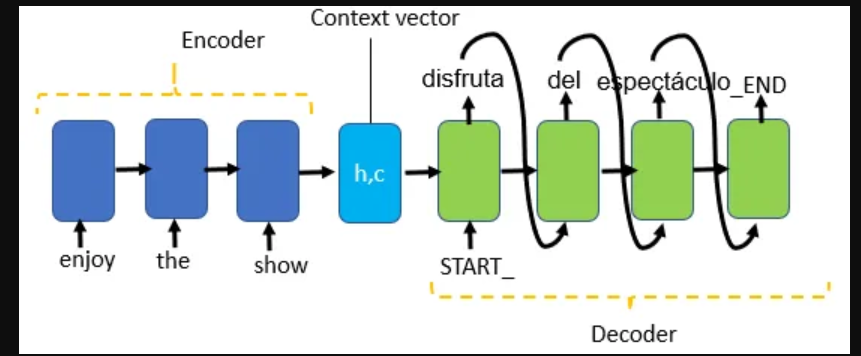

In [25]:
# Encoder model (same as in training)
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup for inference
# These inputs will hold the LSTM states for each timestep
decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_input_h')
decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Embedding layer reused from training
dec_emb2 = dec_emb_layer(decoder_inputs)

# Reuse the LSTM layer and pass in the previous states
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=decoder_states_inputs
)
decoder_states2 = [state_h2, state_c2]

# Reuse the dense softmax layer
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final inference decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

### Function for Quick Predictions.

In [26]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of
    #target sequence with the start character.
    target_seq[0, 0] = target_word2idx['START_']
# Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
# Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word =target_idx2word[sampled_token_index]
        decoded_sentence += ' '+ sampled_word
# Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True
# Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
# Update states
        states_value = [h, c]
    return decoded_sentence

In [27]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [31]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Source sentence:', X_train[k:k+1].values[0])
print('Actual Target Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Target Translation:', decoded_sentence[:-4])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Input Source sentence: i read lips.
Actual Target Translation:  म ओठ पढ्छु । 
Predicted Target Translation:  म 
